In [1]:
import io
import math
import re
from pathlib import Path

from tqdm.notebook import tqdm
from IPython.display import SVG
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import requests
import pypowsybl as pp


try:
    import entsoe_secrets
    token = entsoe_secrets.token
    proxies = entsoe_secrets.proxies
except ImportError:
    # To get a token to use Entsoe RESTful API:
    # - first, register at https://transparency.entsoe.eu
    # - once registered, send an email to transparency@entsoe.eu with “Restful API access” in the subject line.
    #   Indicate the email address you entered during registration in the email body. 
    token = "put you token here"
    # If you are behind a corporate proxy, you have to define the following dict
    # proxies = {
    #     "http": "http://your_login:your_passwd@ip_address_of_proxy:port_number",
    #     "https": "http://your_login:your_passwd@ip_address_of_proxy:port_number"
    # }
    proxies = {}
colors = ["#006BA4", "#FF800E", "#ABABAB", "#595959", "#5F9ED1", "#C85200", "#898989", "#A2C8EC", "#FFBC79", "#CFCFCF"]

# Load the French, Spanish and Portuguese networks using pyPowsyBl

In [845]:
boundary_set = "20211216T1459Z_ENTSO-E_BD_1346.zip"
parameters = {
    "iidm.import.cgmes.boundary-location": str((Path("./data") / boundary_set).resolve()),    # the boundary set will be imported
    "iidm.import.cgmes.source-for-iidm-id": "rdfID",        # rdfID will be used as id for elements
}
models = {
    "FR": "FR_3PQT_v3.zip",
    "ES": "ES_3PQT.zip",
    "PT": "PT_3PQTv2.zip",
}
networks = {}
for tso, model in tqdm(models.items()):
    networks[tso] = pp.network.load(Path("./data") / model, parameters=parameters)
network = networks["FR"]
network.merge([networks["ES"], networks["PT"]])

  0%|          | 0/3 [00:00<?, ?it/s]

## Quick tour on how to access elements defined in the network

### Voltage levels

In [846]:
voltage_levels = network.get_voltage_levels()
voltage_levels.head()

name   
id                                               
_b4d6ea64-9009-5cdc-9329-70c565e1545c  ZGRENP6  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7  BRIZEP6   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485  PREGUP6   
_204145f6-f652-55ea-b1c9-7199a193a16e  2G.SOP7   
_846af0fb-a67c-56f3-8c54-95b67c029b6b  COUCHP6   

                                                               substation_id   
id                                                                             
_b4d6ea64-9009-5cdc-9329-70c565e1545c  _29a7291a-dfd4-5544-979b-b7572297d3fb  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7  _d0a3de41-18cd-5f63-aa42-6c8deda914f4   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485  _fb59f259-95c3-5939-8f3d-c653f45f4e4a   
_204145f6-f652-55ea-b1c9-7199a193a16e  _49bdf487-bd72-5231-a520-3d3699958bbe   
_846af0fb-a67c-56f3-8c54-95b67c029b6b  _575b4fbf-d4ef-5d48-a578-42bfd8bb7666   

                                       nominal_v  high_voltage_limit   
id                                                                     
_b4d6ea64-9009-5cdc-9329-70c565e1545c      225.0               245.0  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7      225.0               245.0   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485      225.0               245.0   
_204145f6-f652-55ea-b1c9-7199a193a16e      380.0               420.0   
_846af0fb-a67c-56f3-8c54-95b67c029b6b      225.0               245.0   

                                       low_voltage_limit  
id                                                        
_b4d6ea64-9009-5cdc-9329-70c565e1545c              200.0  
_33afac39-315e-5c14-b5cc-d24dfc0446e7              200.0  
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485              200.0  
_204145f6-f652-55ea-b1c9-7199a193a16e              380.0  
_846af0fb-a67c-56f3-8c54-95b67c029b6b              200.0

In [847]:
voltage_levels = voltage_levels[["name", "substation_id", "nominal_v"]]

### Substations

In [848]:
substations = network.get_substations(attributes=["name", "CGMES.regionName", "geo_tags"])
substations.head()

name   
id                                                                                  
_1a73a6d9-fb12-5538-9bbd-499bcc64d122  GALER_1a73a6d9-fb12-5538-9bbd-499bcc64d122  \
_7bc9ff12-1775-5e3d-9b3f-e4b5c7dc7bf5  ZMAR8_7bc9ff12-1775-5e3d-9b3f-e4b5c7dc7bf5   
_fa43f1c7-19b8-54a8-84c4-91e7352eb465  ROSPE_fa43f1c7-19b8-54a8-84c4-91e7352eb465   
_d46bb4eb-39f5-5f42-9091-3ffa2182625d  HERRE_d46bb4eb-39f5-5f42-9091-3ffa2182625d   
_cd47488a-8aaf-5d0c-8fa2-96836f50d838  ZVA10_cd47488a-8aaf-5d0c-8fa2-96836f50d838   

                                      CGMES.regionName       geo_tags  
id                                                                     
_1a73a6d9-fb12-5538-9bbd-499bcc64d122           FRANCE      RTE-PARIS  
_7bc9ff12-1775-5e3d-9b3f-e4b5c7dc7bf5           FRANCE       RTE-LYON  
_fa43f1c7-19b8-54a8-84c4-91e7352eb465           FRANCE     RTE-NANTES  
_d46bb4eb-39f5-5f42-9091-3ffa2182625d           FRANCE      RTE-NANCY  
_cd47488a-8aaf-5d0c-8fa2-96836f50d838           FRANCE  RTE-MARSEILLE

### Loads

In [849]:
loads = network.get_loads()
loads.head()

name       type        p0   
id                                                                        
_2195540c-d88c-50e2-b375-ec38b0bb2048   CHATI6T613  UNDEFINED   36.9196  \
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8    CUSTIP61A  UNDEFINED   65.3261   
_6b938c96-366d-5c6e-9d2a-b56b01cfecda  SAISI2TR211  UNDEFINED    0.0000   
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469    FLOIRP61A  UNDEFINED  202.9520   
_5486639d-7ddd-5439-9d29-0f31dbac3cfe     EQUINJ_3  UNDEFINED   55.5912   

                                              q0         p          q   
id                                                                      
_2195540c-d88c-50e2-b375-ec38b0bb2048  -0.431972   36.9196  -0.431972  \
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  17.018000   65.3261  17.018000   
_6b938c96-366d-5c6e-9d2a-b56b01cfecda   0.000000    0.0000   0.000000   
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469  24.333300  202.9520  24.333300   
_5486639d-7ddd-5439-9d29-0f31dbac3cfe   3.299180   55.5912   3.299180   

                                                i   
id                                                  
_2195540c-d88c-50e2-b375-ec38b0bb2048   88.090053  \
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  160.470144   
_6b938c96-366d-5c6e-9d2a-b56b01cfecda    0.000000   
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469  487.974033   
_5486639d-7ddd-5439-9d29-0f31dbac3cfe  133.547936   

                                                            voltage_level_id   
id                                                                             
_2195540c-d88c-50e2-b375-ec38b0bb2048  _84b42987-c7f8-5516-9f48-21b3e510fea5  \
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  _6b5b82a3-aab5-59ce-bf3e-1a524702f5ce   
_6b938c96-366d-5c6e-9d2a-b56b01cfecda  _8671dadd-59f8-51f4-805e-fb399e0a39ff   
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469  _c39950a7-5631-52b7-80ca-110e553e5d73   
_5486639d-7ddd-5439-9d29-0f31dbac3cfe  _cfbdb877-7bcb-5bea-962e-895552a04233   

                                                                        bus_id   
id                                                                               
_2195540c-d88c-50e2-b375-ec38b0bb2048  _84b42987-c7f8-5516-9f48-21b3e510fea5_0  \
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  _6b5b82a3-aab5-59ce-bf3e-1a524702f5ce_0   
_6b938c96-366d-5c6e-9d2a-b56b01cfecda  _8671dadd-59f8-51f4-805e-fb399e0a39ff_0   
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469  _c39950a7-5631-52b7-80ca-110e553e5d73_0   
_5486639d-7ddd-5439-9d29-0f31dbac3cfe  _cfbdb877-7bcb-5bea-962e-895552a04233_0   

                                       connected  
id                                                
_2195540c-d88c-50e2-b375-ec38b0bb2048       True  
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8       True  
_6b938c96-366d-5c6e-9d2a-b56b01cfecda       True  
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469       True  
_5486639d-7ddd-5439-9d29-0f31dbac3cfe       True

In [850]:
loads = loads[["p0", "bus_id", "voltage_level_id"]]
loads.head()

p0   
id                                                
_2195540c-d88c-50e2-b375-ec38b0bb2048   36.9196  \
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8   65.3261   
_6b938c96-366d-5c6e-9d2a-b56b01cfecda    0.0000   
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469  202.9520   
_5486639d-7ddd-5439-9d29-0f31dbac3cfe   55.5912   

                                                                        bus_id   
id                                                                               
_2195540c-d88c-50e2-b375-ec38b0bb2048  _84b42987-c7f8-5516-9f48-21b3e510fea5_0  \
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  _6b5b82a3-aab5-59ce-bf3e-1a524702f5ce_0   
_6b938c96-366d-5c6e-9d2a-b56b01cfecda  _8671dadd-59f8-51f4-805e-fb399e0a39ff_0   
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469  _c39950a7-5631-52b7-80ca-110e553e5d73_0   
_5486639d-7ddd-5439-9d29-0f31dbac3cfe  _cfbdb877-7bcb-5bea-962e-895552a04233_0   

                                                            voltage_level_id  
id                                                                            
_2195540c-d88c-50e2-b375-ec38b0bb2048  _84b42987-c7f8-5516-9f48-21b3e510fea5  
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  _6b5b82a3-aab5-59ce-bf3e-1a524702f5ce  
_6b938c96-366d-5c6e-9d2a-b56b01cfecda  _8671dadd-59f8-51f4-805e-fb399e0a39ff  
_cc9c6c24-0ea5-5e7b-aca4-a0e2f01d5469  _c39950a7-5631-52b7-80ca-110e553e5d73  
_5486639d-7ddd-5439-9d29-0f31dbac3cfe  _cfbdb877-7bcb-5bea-962e-895552a04233

### Generators

In [851]:
generators = network.get_generators()
generators.head()

name energy_source   
id                                                                    
_0db42f31-8426-5307-a406-b8f94471c6a4      ETUPEP61PV         OTHER  \
_c6325120-bf04-53dc-8660-1970c436010c      CHAV6P61TU         HYDRO   
_1021b91f-fac6-5d21-9f1c-afac5e83968f         BORALEX          WIND   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa  PYRAMP6_PV_CHG         OTHER   
_76498da7-2ebe-5226-b643-c4698791524a      MARSIP71TH         OTHER   

                                        target_p  min_p     max_p    min_q   
id                                                                           
_0db42f31-8426-5307-a406-b8f94471c6a4  35.310200    0.0  55.84860   0.0000  \
_c6325120-bf04-53dc-8660-1970c436010c  16.616300    0.0  41.31380 -12.8100   
_1021b91f-fac6-5d21-9f1c-afac5e83968f   2.370460    0.0  44.66090 -24.6369   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa   0.931054    0.0   1.47261  -0.4400   
_76498da7-2ebe-5226-b643-c4698791524a   5.596720    0.0  14.40320 -26.5340   

                                         max_q   rated_s reactive_limits_kind   
id                                                                              
_0db42f31-8426-5307-a406-b8f94471c6a4   0.0000  55.84860              MIN_MAX  \
_c6325120-bf04-53dc-8660-1970c436010c  12.8100  43.25420              MIN_MAX   
_1021b91f-fac6-5d21-9f1c-afac5e83968f  24.6369  51.00560              MIN_MAX   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa   0.4400   1.53694              MIN_MAX   
_76498da7-2ebe-5226-b643-c4698791524a  26.5340  30.19110              MIN_MAX   

                                       target_v   target_q   
id                                                           
_0db42f31-8426-5307-a406-b8f94471c6a4       NaN   0.000000  \
_c6325120-bf04-53dc-8660-1970c436010c   231.511  10.254600   
_1021b91f-fac6-5d21-9f1c-afac5e83968f   244.000  24.636900   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa   241.360  -0.001534   
_76498da7-2ebe-5226-b643-c4698791524a   409.788 -26.534000   

                                       voltage_regulator_on   
id                                                            
_0db42f31-8426-5307-a406-b8f94471c6a4                 False  \
_c6325120-bf04-53dc-8660-1970c436010c                 False   
_1021b91f-fac6-5d21-9f1c-afac5e83968f                  True   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa                 False   
_76498da7-2ebe-5226-b643-c4698791524a                 False   

                                                        regulated_element_id   
id                                                                             
_0db42f31-8426-5307-a406-b8f94471c6a4  _0db42f31-8426-5307-a406-b8f94471c6a4  \
_c6325120-bf04-53dc-8660-1970c436010c  _c6325120-bf04-53dc-8660-1970c436010c   
_1021b91f-fac6-5d21-9f1c-afac5e83968f  _1021b91f-fac6-5d21-9f1c-afac5e83968f   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa  _5df318f7-97c0-51e8-84ac-11f7f0dd74aa   
_76498da7-2ebe-5226-b643-c4698791524a  _76498da7-2ebe-5226-b643-c4698791524a   

                                               p          q          i   
id                                                                       
_0db42f31-8426-5307-a406-b8f94471c6a4 -35.310200  -0.000000  89.116386  \
_c6325120-bf04-53dc-8660-1970c436010c -16.616300 -10.254600  48.774061   
_1021b91f-fac6-5d21-9f1c-afac5e83968f  -2.370460 -24.636900  58.610671   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa  -0.931054   0.001534   2.227196   
_76498da7-2ebe-5226-b643-c4698791524a  -5.596720  26.534000  38.271583   

                                                            voltage_level_id   
id                                                                             
_0db42f31-8426-5307-a406-b8f94471c6a4  _21e8509d-068a-5cac-8e32-c8b828fc72f9  \
_c6325120-bf04-53dc-8660-1970c436010c  _eda04371-a5cb-5329-a8c6-895ea2abb7a6   
_1021b91f-fac6-5d21-9f1c-afac5e83968f  _d4b9dc4d-0795-514d-a5cb-12fa35a87e65   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa  _15a39692-e2e5-5e1b-a88c-7720aba74206   

In [852]:
generators = generators[["name", "energy_source", "target_p", "max_p", "bus_id", "voltage_level_id"]]
generators.head()

name energy_source   
id                                                                    
_0db42f31-8426-5307-a406-b8f94471c6a4      ETUPEP61PV         OTHER  \
_c6325120-bf04-53dc-8660-1970c436010c      CHAV6P61TU         HYDRO   
_1021b91f-fac6-5d21-9f1c-afac5e83968f         BORALEX          WIND   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa  PYRAMP6_PV_CHG         OTHER   
_76498da7-2ebe-5226-b643-c4698791524a      MARSIP71TH         OTHER   

                                        target_p     max_p   
id                                                           
_0db42f31-8426-5307-a406-b8f94471c6a4  35.310200  55.84860  \
_c6325120-bf04-53dc-8660-1970c436010c  16.616300  41.31380   
_1021b91f-fac6-5d21-9f1c-afac5e83968f   2.370460  44.66090   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa   0.931054   1.47261   
_76498da7-2ebe-5226-b643-c4698791524a   5.596720  14.40320   

                                                                        bus_id   
id                                                                               
_0db42f31-8426-5307-a406-b8f94471c6a4  _21e8509d-068a-5cac-8e32-c8b828fc72f9_0  \
_c6325120-bf04-53dc-8660-1970c436010c  _eda04371-a5cb-5329-a8c6-895ea2abb7a6_0   
_1021b91f-fac6-5d21-9f1c-afac5e83968f  _d4b9dc4d-0795-514d-a5cb-12fa35a87e65_0   
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa  _15a39692-e2e5-5e1b-a88c-7720aba74206_0   
_76498da7-2ebe-5226-b643-c4698791524a  _6ed5aa25-35cb-5b3d-8999-238e10d820ec_0   

                                                            voltage_level_id  
id                                                                            
_0db42f31-8426-5307-a406-b8f94471c6a4  _21e8509d-068a-5cac-8e32-c8b828fc72f9  
_c6325120-bf04-53dc-8660-1970c436010c  _eda04371-a5cb-5329-a8c6-895ea2abb7a6  
_1021b91f-fac6-5d21-9f1c-afac5e83968f  _d4b9dc4d-0795-514d-a5cb-12fa35a87e65  
_5df318f7-97c0-51e8-84ac-11f7f0dd74aa  _15a39692-e2e5-5e1b-a88c-7720aba74206  
_76498da7-2ebe-5226-b643-c4698791524a  _6ed5aa25-35cb-5b3d-8999-238e10d820ec

### Buses

In [853]:
buses = network.get_buses()
buses.head()

name    v_mag   v_angle   
id                                                                      
_b4d6ea64-9009-5cdc-9329-70c565e1545c_0  ZGRENP6_0  233.604  34.51210  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7_0  BRIZEP6_0  238.110  73.11030   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485_0  PREGUP6_0  229.479  85.33510   
_204145f6-f652-55ea-b1c9-7199a193a16e_0  2G.SOP7_0  408.367   9.39078   
_846af0fb-a67c-56f3-8c54-95b67c029b6b_0  COUCHP6_0  239.963  12.09260   

                                         connected_component   
id                                                             
_b4d6ea64-9009-5cdc-9329-70c565e1545c_0                    0  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7_0                    0   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485_0                    0   
_204145f6-f652-55ea-b1c9-7199a193a16e_0                    0   
_846af0fb-a67c-56f3-8c54-95b67c029b6b_0                    0   

                                         synchronous_component   
id                                                               
_b4d6ea64-9009-5cdc-9329-70c565e1545c_0                      0  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7_0                      0   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485_0                      0   
_204145f6-f652-55ea-b1c9-7199a193a16e_0                      0   
_846af0fb-a67c-56f3-8c54-95b67c029b6b_0                      0   

                                                              voltage_level_id  
id                                                                              
_b4d6ea64-9009-5cdc-9329-70c565e1545c_0  _b4d6ea64-9009-5cdc-9329-70c565e1545c  
_33afac39-315e-5c14-b5cc-d24dfc0446e7_0  _33afac39-315e-5c14-b5cc-d24dfc0446e7  
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485_0  _4fc663f1-eff6-52e0-ab39-2c5b25c6f485  
_204145f6-f652-55ea-b1c9-7199a193a16e_0  _204145f6-f652-55ea-b1c9-7199a193a16e  
_846af0fb-a67c-56f3-8c54-95b67c029b6b_0  _846af0fb-a67c-56f3-8c54-95b67c029b6b

In [854]:
buses = buses[["synchronous_component"]]
buses.head()

synchronous_component
id                                                            
_b4d6ea64-9009-5cdc-9329-70c565e1545c_0                      0
_33afac39-315e-5c14-b5cc-d24dfc0446e7_0                      0
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485_0                      0
_204145f6-f652-55ea-b1c9-7199a193a16e_0                      0
_846af0fb-a67c-56f3-8c54-95b67c029b6b_0                      0

## Build interesting dataframes

### For voltage_levels

In [855]:
voltage_levels = voltage_levels.merge(substations, left_on="substation_id", right_index=True, suffixes=("", "_subst"))
voltage_levels.head()

name   
id                                               
_b4d6ea64-9009-5cdc-9329-70c565e1545c  ZGRENP6  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7  BRIZEP6   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485  PREGUP6   
_11089d97-9365-5806-b951-dba828a85500  PREGUP7   
_204145f6-f652-55ea-b1c9-7199a193a16e  2G.SOP7   

                                                               substation_id   
id                                                                             
_b4d6ea64-9009-5cdc-9329-70c565e1545c  _29a7291a-dfd4-5544-979b-b7572297d3fb  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7  _d0a3de41-18cd-5f63-aa42-6c8deda914f4   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485  _fb59f259-95c3-5939-8f3d-c653f45f4e4a   
_11089d97-9365-5806-b951-dba828a85500  _fb59f259-95c3-5939-8f3d-c653f45f4e4a   
_204145f6-f652-55ea-b1c9-7199a193a16e  _49bdf487-bd72-5231-a520-3d3699958bbe   

                                       nominal_v   
id                                                 
_b4d6ea64-9009-5cdc-9329-70c565e1545c      225.0  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7      225.0   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485      225.0   
_11089d97-9365-5806-b951-dba828a85500      380.0   
_204145f6-f652-55ea-b1c9-7199a193a16e      380.0   

                                                                       name_subst   
id                                                                                  
_b4d6ea64-9009-5cdc-9329-70c565e1545c  ZGREN_29a7291a-dfd4-5544-979b-b7572297d3fb  \
_33afac39-315e-5c14-b5cc-d24dfc0446e7  BRIZE_d0a3de41-18cd-5f63-aa42-6c8deda914f4   
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485  PREGU_fb59f259-95c3-5939-8f3d-c653f45f4e4a   
_11089d97-9365-5806-b951-dba828a85500  PREGU_fb59f259-95c3-5939-8f3d-c653f45f4e4a   
_204145f6-f652-55ea-b1c9-7199a193a16e  G.SOL_49bdf487-bd72-5231-a520-3d3699958bbe   

                                      CGMES.regionName    geo_tags  
id                                                                  
_b4d6ea64-9009-5cdc-9329-70c565e1545c           FRANCE    RTE-LYON  
_33afac39-315e-5c14-b5cc-d24dfc0446e7           FRANCE  RTE-NANTES  
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485           FRANCE  RTE-NANTES  
_11089d97-9365-5806-b951-dba828a85500           FRANCE  RTE-NANTES  
_204145f6-f652-55ea-b1c9-7199a193a16e           FRANCE   RTE-PARIS

### For generators

In [856]:
generators = generators.merge(buses, left_on="bus_id", right_index=True, how="left")
generators = generators.merge(voltage_levels, left_on="voltage_level_id", right_index=True, suffixes=("", "_vl"))
generators = generators[generators["synchronous_component"] == 0]
generators.head()

name energy_source  target_p   
id                                                                              
_0db42f31-8426-5307-a406-b8f94471c6a4      ETUPEP61PV         OTHER  35.31020  \
_bf2a8a34-f4bc-53c5-8407-752f5ee41c9b  ETUPEP6_PV_CHG         OTHER   3.73586   
_53199020-3d80-501f-b60e-32057335c7f8      ETUPEP61TU         HYDRO   2.36026   
_8280007c-4745-5631-8d70-25d68b8d3c2a      ETUPEP61BM         OTHER   6.06313   
_596cdbbd-b786-559d-9afa-18d9134debf4      ETUPEP61TH         OTHER   2.58735   

                                          max_p   
id                                                
_0db42f31-8426-5307-a406-b8f94471c6a4  55.84860  \
_bf2a8a34-f4bc-53c5-8407-752f5ee41c9b   5.90883   
_53199020-3d80-501f-b60e-32057335c7f8   5.86844   
_8280007c-4745-5631-8d70-25d68b8d3c2a  11.34770   
_596cdbbd-b786-559d-9afa-18d9134debf4   6.65855   

                                                                        bus_id   
id                                                                               
_0db42f31-8426-5307-a406-b8f94471c6a4  _21e8509d-068a-5cac-8e32-c8b828fc72f9_0  \
_bf2a8a34-f4bc-53c5-8407-752f5ee41c9b  _21e8509d-068a-5cac-8e32-c8b828fc72f9_0   
_53199020-3d80-501f-b60e-32057335c7f8  _21e8509d-068a-5cac-8e32-c8b828fc72f9_0   
_8280007c-4745-5631-8d70-25d68b8d3c2a  _21e8509d-068a-5cac-8e32-c8b828fc72f9_0   
_596cdbbd-b786-559d-9afa-18d9134debf4  _21e8509d-068a-5cac-8e32-c8b828fc72f9_0   

                                                            voltage_level_id   
id                                                                             
_0db42f31-8426-5307-a406-b8f94471c6a4  _21e8509d-068a-5cac-8e32-c8b828fc72f9  \
_bf2a8a34-f4bc-53c5-8407-752f5ee41c9b  _21e8509d-068a-5cac-8e32-c8b828fc72f9   
_53199020-3d80-501f-b60e-32057335c7f8  _21e8509d-068a-5cac-8e32-c8b828fc72f9   
_8280007c-4745-5631-8d70-25d68b8d3c2a  _21e8509d-068a-5cac-8e32-c8b828fc72f9   
_596cdbbd-b786-559d-9afa-18d9134debf4  _21e8509d-068a-5cac-8e32-c8b828fc72f9   

                                       synchronous_component  name_vl   
id                                                                      
_0db42f31-8426-5307-a406-b8f94471c6a4                    0.0  ETUPEP6  \
_bf2a8a34-f4bc-53c5-8407-752f5ee41c9b                    0.0  ETUPEP6   
_53199020-3d80-501f-b60e-32057335c7f8                    0.0  ETUPEP6   
_8280007c-4745-5631-8d70-25d68b8d3c2a                    0.0  ETUPEP6   
_596cdbbd-b786-559d-9afa-18d9134debf4                    0.0  ETUPEP6   

                                                               substation_id   
id                                                                             
_0db42f31-8426-5307-a406-b8f94471c6a4  _34b1d99b-1a0c-5e88-bf0a-af78c4883df2  \
_bf2a8a34-f4bc-53c5-8407-752f5ee41c9b  _34b1d99b-1a0c-5e88-bf0a-af78c4883df2   
_53199020-3d80-501f-b60e-32057335c7f8  _34b1d99b-1a0c-5e88-bf0a-af78c4883df2   
_8280007c-4745-5631-8d70-25d68b8d3c2a  _34b1d99b-1a0c-5e88-bf0a-af78c4883df2   
_596cdbbd-b786-559d-9afa-18d9134debf4  _34b1d99b-1a0c-5e88-bf0a-af78c4883df2   

                                       nominal_v   
id                                                 
_0db42f31-8426-5307-a406-b8f94471c6a4      225.0  \
_bf2a8a34-f4bc-53c5-8407-752f5ee41c9b      225.0   
_53199020-3d80-501f-b60e-32057335c7f8      225.0   
_8280007c-4745-5631-8d70-25d68b8d3c2a      225.0   
_596cdbbd-b786-559d-9afa-18d9134debf4      225.0   

                                                                       name_subst   
id                                                                                  
_0db42f31-8426-5307-a406-b8f94471c6a4  ETUPE_34b1d99b-1a0c-5e88-bf0a-af78c4883df2  \
_bf2a8a34-f4bc-53c5-8407-752f5ee41c9b  ETUPE_34b1d99b-1a0c-5e88-bf0a-af78c4883df2   
_53199020-3d80-501f-b60e-32057335c7f8  ETUPE_34b1d99b-1a0c-5e88-bf0a-af78c4883df2   
_8280007c-4745-5631-8d70-25d68b8d3c2a  ETUPE_34b1d99b-1a0c-5e88-bf0a-af78c4883df2   
_596cdbbd-b786-559d-9afa-18d9134debf4  

### For loads

In [857]:
loads = loads.merge(buses, left_on="bus_id", right_index=True, how="left")
loads = loads.merge(voltage_levels, left_on="voltage_level_id", right_index=True, suffixes=("", "_vl"))
loads = loads[loads["synchronous_component"] == 0]
loads.head()

p0   
id                                               
_2195540c-d88c-50e2-b375-ec38b0bb2048  36.9196  \
_7724dd02-eca0-58c6-8cf4-9d0347159b7f  38.0383   
_6d2da8aa-b6e2-5107-a842-f78cb5d020d6  36.9196   
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  65.3261   
_37f4f8bc-24ac-5fa1-8d86-15fc28a233d4  20.9132   

                                                                        bus_id   
id                                                                               
_2195540c-d88c-50e2-b375-ec38b0bb2048  _84b42987-c7f8-5516-9f48-21b3e510fea5_0  \
_7724dd02-eca0-58c6-8cf4-9d0347159b7f  _84b42987-c7f8-5516-9f48-21b3e510fea5_1   
_6d2da8aa-b6e2-5107-a842-f78cb5d020d6  _84b42987-c7f8-5516-9f48-21b3e510fea5_1   
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  _6b5b82a3-aab5-59ce-bf3e-1a524702f5ce_0   
_37f4f8bc-24ac-5fa1-8d86-15fc28a233d4  _6b5b82a3-aab5-59ce-bf3e-1a524702f5ce_0   

                                                            voltage_level_id   
id                                                                             
_2195540c-d88c-50e2-b375-ec38b0bb2048  _84b42987-c7f8-5516-9f48-21b3e510fea5  \
_7724dd02-eca0-58c6-8cf4-9d0347159b7f  _84b42987-c7f8-5516-9f48-21b3e510fea5   
_6d2da8aa-b6e2-5107-a842-f78cb5d020d6  _84b42987-c7f8-5516-9f48-21b3e510fea5   
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  _6b5b82a3-aab5-59ce-bf3e-1a524702f5ce   
_37f4f8bc-24ac-5fa1-8d86-15fc28a233d4  _6b5b82a3-aab5-59ce-bf3e-1a524702f5ce   

                                       synchronous_component     name   
id                                                                      
_2195540c-d88c-50e2-b375-ec38b0bb2048                    0.0  CHATIP6  \
_7724dd02-eca0-58c6-8cf4-9d0347159b7f                    0.0  CHATIP6   
_6d2da8aa-b6e2-5107-a842-f78cb5d020d6                    0.0  CHATIP6   
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8                    0.0  CUSTIP6   
_37f4f8bc-24ac-5fa1-8d86-15fc28a233d4                    0.0  CUSTIP6   

                                                               substation_id   
id                                                                             
_2195540c-d88c-50e2-b375-ec38b0bb2048  _c241bc6a-6807-5898-bdd5-5e99552f9526  \
_7724dd02-eca0-58c6-8cf4-9d0347159b7f  _c241bc6a-6807-5898-bdd5-5e99552f9526   
_6d2da8aa-b6e2-5107-a842-f78cb5d020d6  _c241bc6a-6807-5898-bdd5-5e99552f9526   
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  _afdc7562-dec8-5939-99fd-90e9738df5b3   
_37f4f8bc-24ac-5fa1-8d86-15fc28a233d4  _afdc7562-dec8-5939-99fd-90e9738df5b3   

                                       nominal_v   
id                                                 
_2195540c-d88c-50e2-b375-ec38b0bb2048      225.0  \
_7724dd02-eca0-58c6-8cf4-9d0347159b7f      225.0   
_6d2da8aa-b6e2-5107-a842-f78cb5d020d6      225.0   
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8      225.0   
_37f4f8bc-24ac-5fa1-8d86-15fc28a233d4      225.0   

                                                                       name_subst   
id                                                                                  
_2195540c-d88c-50e2-b375-ec38b0bb2048  CHATI_c241bc6a-6807-5898-bdd5-5e99552f9526  \
_7724dd02-eca0-58c6-8cf4-9d0347159b7f  CHATI_c241bc6a-6807-5898-bdd5-5e99552f9526   
_6d2da8aa-b6e2-5107-a842-f78cb5d020d6  CHATI_c241bc6a-6807-5898-bdd5-5e99552f9526   
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8  CUSTI_afdc7562-dec8-5939-99fd-90e9738df5b3   
_37f4f8bc-24ac-5fa1-8d86-15fc28a233d4  CUSTI_afdc7562-dec8-5939-99fd-90e9738df5b3   

                                      CGMES.regionName   geo_tags  
id                                                                 
_2195540c-d88c-50e2-b375-ec38b0bb2048           FRANCE  RTE-PARIS  
_7724dd02-eca0-58c6-8cf4-9d0347159b7f           FRANCE  RTE-PARIS  
_6d2da8aa-b6e2-5107-a842-f78cb5d020d6           FRANCE  RTE-PARIS  
_0ae14145-ad59-5a11-9b5c-d2d0fe44eaa8           FRANCE  RTE-NANCY  
_37f4f8bc-24ac-5fa1-8d86-15fc28a233d4           FRANCE  RTE-NANCY

In [858]:
def display_voltage_level(voltage_level_name):
    vl = network.get_voltage_levels(attributes=["name"])
    if voltage_level_name in vl.index:
        vl_id = voltage_level_name
    else:
        vl_id = vl[vl["name"] == voltage_level_name].index[0]
    return network.get_single_line_diagram(
        vl_id,
        pp.network.SldParameters(
            use_name=True,
            diagonal_label=True,
            topological_coloring=True,
            nodes_infos=False,
            tooltip_enabled=True,
        )
    )

## Geographical representation of the network near the France - Spain border

### Using OpenData (https://odre.opendatasoft.com/explore) to get RTE substations coordinatees

In [275]:
vl_for_gps_fr = (
    voltage_levels[
        # Only south-west french network
        (voltage_levels["geo_tags"] == "RTE-TOULOUSE")
        # 220 kV and 400 kV
        & (voltage_levels["nominal_v"] >= 220)
        # don't take into account fictitious substations 
        & (~voltage_levels["name"].str.startswith(("1", "2", "3")))
    ]
)
subst_for_gps_fr = vl_for_gps_fr.set_index("substation_id")["name"].str[:-2].str.strip().to_frame()

All RTE substations coordinates can be found at https://odre.opendatasoft.com/explore/dataset/postes-electriques-rte/table/?disjunctive.fonction&disjunctive.etat&disjunctive.tension&sort=-code_poste

In [216]:
gps_coords_fr = (
    pd.read_csv(
        Path("./data") / "postes-electriques-rte.csv",
        sep=";",
        encoding="latin1",
        usecols=["Code poste", "Longitude poste (DD)", "Latitude poste (DD)"]
    )
    .rename(columns={"Longitude poste (DD)": "longitude", "Latitude poste (DD)": "latitude"})
    .set_index("Code poste")
)
# Unknown coordinates for BEHLA substation : put it arbitratry in the middle of the line CANTEL71SAUCA (and little longitude deviation to better see the double circuit)
gps_coords_fr.loc["BEHLA"] = (gps_coords_fr.loc["CANTE"] + gps_coords_fr.loc["SAUCA"]) / 2
gps_coords_fr.loc["BEHLA", "longitude"] += 0.1

### Using geocoder service to find GPS coordinates of Red Electrica substations

In [223]:
idx_es = network.get_network_area_diagram_displayed_voltage_levels(
    # Only substations close to the border
    list(voltage_levels[voltage_levels["name"].isin(["HERNANI", "BIESCAS", "VIC", "LLOGAIA"])].index),
    depth=2
)
subst_for_gps_es =  (
    voltage_levels
    .loc[idx_es]
    .loc[(voltage_levels["CGMES.regionName"] == "ES") & (voltage_levels["nominal_v"] > 200)][["substation_id", "name"]]
    .drop_duplicates(subset=["substation_id"])
    .set_index("substation_id")["name"].to_frame()
)
subst_for_gps_es.head()

name
substation_id                                  
_4a12abd7-edcf-b61e-50b3-148d6e753306   LAFARGA
_81bedfd1-0bd1-d32b-3adf-e8d517f3f1f1   PIEROLA
_85cabc40-aa49-26a8-ac2a-49996157a524  SENTMENA
_2c90df6b-8b3d-5dfd-6903-146a4228eed9   HERNANI
_7bd0bd0a-5d05-a383-c551-e04eb642c091  VANDELLO

In [191]:
city = {
    "LAFARGA": "JUIA",
    "RIUDAREN": "RIUDARENES",
    "SABINANI": "SABINANIGO",
    "GATICA": "GATIKA",
    "LAROCA": "LA ROCA VILLAGE",
    "SENTMENA": "SENTMENAT",
    "TESCALON": "ESCALONA ARAGON",
    "FRANQUES": "FRANQUESES",
    "PALAU": "PALAU-SOLITA",
    "CASTEJON": "CASTEJON DE EBRO",
    "ABANTO": "ABANTO Y",
    "AMOREBIE": "AMOREBIETA",
}

In [192]:
from geopy.geocoders import Nominatim
import time
geolocator = Nominatim(user_agent="ntc_with_pypowsybl", proxies=proxies)
gps_coords_es = {}
for _, subst in tqdm(subst_for_gps_es.drop_duplicates(subset="name").iterrows()):
    location = geolocator.geocode(query={"city": city.get(subst["name"],subst["name"]) }, country_codes="es")
    if not location:
        location = geolocator.geocode(subst["name"],country_codes="es")
    try:
        gps_coords_es[subst["name"]] = (location.latitude, location.longitude)
    except:
        pass
    time.sleep(1.1)

0it [00:00, ?it/s]

In [226]:
coords_es = subst_for_gps_es.merge(pd.DataFrame.from_dict(gps_coords_es, orient="index", columns=["latitude", "longitude"]), left_on="name", right_index=True)
coords_es.head()

name   latitude  longitude
substation_id                                                        
_4a12abd7-edcf-b61e-50b3-148d6e753306   LAFARGA  42.017297   2.906718
_81bedfd1-0bd1-d32b-3adf-e8d517f3f1f1   PIEROLA  41.549160   1.788563
_85cabc40-aa49-26a8-ac2a-49996157a524  SENTMENA  41.611050   2.137446
_2c90df6b-8b3d-5dfd-6903-146a4228eed9   HERNANI  43.266111  -1.974742
_9eff1974-ca01-b1a1-37a4-54942061f986     PALAU  41.587394   2.180682

In [227]:
coords_fr = gps_coords_fr.merge(subst_for_gps_fr.reset_index(), left_on="Code poste", right_on="name").set_index("substation_id")
coords_fr.head()

longitude   latitude   name
substation_id                                                     
_17b7250e-4ad5-56d7-a7b8-812ba08dc5a0  -0.086927  44.713869  S.GUY
_e9b1eacf-96ad-51f1-a9b5-e1e627baae6f   1.494031  43.616138  BALMA
_21891410-cae7-52cd-b133-1d6db664bbb8   0.039344  43.225114  BASTI
_8e2b9934-fd7d-5aec-a150-e5478af262f7  -0.692848  45.258633  BLAYA
_8e2b9934-fd7d-5aec-a150-e5478af262f7  -0.692848  45.258633  BLAYA

In [228]:
coords_fr_es = pd.concat([coords_fr, coords_es]).rename_axis("id")[["latitude", "longitude"]]
coords_fr_es.head()

latitude  longitude
id                                                         
_17b7250e-4ad5-56d7-a7b8-812ba08dc5a0  44.713869  -0.086927
_e9b1eacf-96ad-51f1-a9b5-e1e627baae6f  43.616138   1.494031
_21891410-cae7-52cd-b133-1d6db664bbb8  43.225114   0.039344
_8e2b9934-fd7d-5aec-a150-e5478af262f7  45.258633  -0.692848
_8e2b9934-fd7d-5aec-a150-e5478af262f7  45.258633  -0.692848

In [446]:
network.remove_extensions('substationPosition', network.get_extensions('substationPosition').index)
network.create_extensions('substationPosition', coords_fr_es[["latitude", "longitude"]])
lines = network.get_lines(["connected1", "connected2"])
network.remove_elements(lines[~lines["connected1"] | ~lines["connected2"]].index)
try:
    import ipywidgets as widgets
    from pypowsybl_jupyter import NetworkMapWidget, display_sld
    out_events = widgets.Output()
    NetworkMapWidget(network, nominal_voltages_top_tiers_filter=5, use_name=True)

except ImportError:
    parameter = pp.network.NadParameters(layout_type=pp.network.NadLayoutType.GEOGRAPHICAL, bus_legend=False)
    SVG(network.get_network_area_diagram(list(vl_for_gps_fr.index.union(vl_for_gps_es.index)), nad_parameters=parameter).svg.replace("25px", "250px").replace("stroke-width: 5", "stroke-width: 15"))

# Calculate yearly flows in the grid

## Network modification

### Create the slack bus

In [859]:
# Create substation
station = pd.DataFrame.from_records(
    index="id",
    data=[
        {"id": "SLACK_SUBST", "country": "TN"},
    ],
)
network.create_substations(station)

# Create voltage level
voltage_level = pd.DataFrame.from_records(
    index="id",
    data=[
        {
            "substation_id": "SLACK_SUBST",
            "id": "SLACK_VL",
            "topology_kind": "BUS_BREAKER",
            "nominal_v": 380,
        },
    ],
)
network.create_voltage_levels(voltage_level)

# Create node
network.create_buses(id=['SLACK_NODE'], voltage_level_id=['SLACK_VL'])

# Create load
load = pd.DataFrame.from_records(
    index="id",
    data=[
        {
            "voltage_level_id": "SLACK_VL",
            "id": "SLACK_LOAD",
            "bus_id": "SLACK_NODE",
            "p0": 5000,
            "q0": 0,
        }
    ],
)
network.create_loads(load)

# Create slack generator
generator = pd.DataFrame.from_records(
    index="id",
    data=[
        {
            "voltage_level_id": "SLACK_VL",
            "id": "SLACK_GROUPE",
            "bus_id": "SLACK_NODE",
            "target_p": 5000,
            "min_p": -100000,
            "max_p": 100000,
            "target_v": 380,
            "voltage_regulator_on": True,
        }
    ],
)
network.create_generators(generator)

# Create the SLACK LINE, connected to TRIP.P7 voltage_level
voltage_level_connection = "TRI.PP7"
voltage_level_connection_id = voltage_levels[voltage_levels["name"] == voltage_level_connection].index[0]
network.create_lines(
    id='SLACK_LINE',
    voltage_level1_id='SLACK_VL',
    bus1_id='SLACK_NODE',
    voltage_level2_id=voltage_level_connection_id,
    bus2_id=network.get_bus_breaker_topology(voltage_level_connection_id).buses.index[0],
    b1=0, b2=0, g1=0, g2=0, r=0.5, x=10
)

In [860]:
parameters_lf = pp.loadflow.Parameters(
    distributed_slack=False,
    provider_parameters={
        "slackBusSelectionMode": "NAME",
        "slackBusesIds": "SLACK_VL",
        "plausibleActivePowerLimit": "20000"
    },
    connected_component_mode=pp.loadflow.ConnectedComponentMode.MAIN,
)
pp.loadflow.run_dc(network, parameters=parameters_lf)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=CONVERGED, iteration_count=0, reference_bus_id='SLACK_VL_0', slack_bus_results=[SlackBusResult(id='SLACK_VL_0', active_power_mismatch=-5453.748383857121)], distributed_active_power=nan)]

In [784]:
display_voltage_level("SLACK_VL")

### Create HVDC Baixas-SLlogaia

In [348]:
voltage_level_from_id = voltage_levels[voltage_levels["name"] == "BAIXAP7"].index[0]
voltage_level_to_id = voltage_levels[voltage_levels["name"] == "LLOGAIA"].index[0]
pp.network.create_vsc_converter_station_bay(
    network,
    id=["Baixas" + '_VSC1', "SLlogaia" + '_VSC2'],
    voltage_regulator_on=[True, True],
    loss_factor=[0, 0],
    target_v=[400, 400],
    bus_or_busbar_section_id=[network.get_bus_breaker_topology(voltage_level_from_id).buses.index[0], network.get_bus_breaker_topology(voltage_level_to_id).buses.index[0]],
    position_order=[1000, 1000],
    raise_exception=True,
)
network.create_hvdc_lines(
    id="BaixasSLlogaia",
    converter_station1_id="Baixas" + "_VSC1",
    converter_station2_id="SLlogaia" + "_VSC2",
    r=0,
    nominal_v=320,
    converters_mode='SIDE_1_RECTIFIER_SIDE_2_INVERTER',
    max_p=2000,
    target_p=0,
)

In [264]:
network.create_hvdc_lines(
    id="BaixasSLogaia",
    converter_station1_id="BaixasSLogaia" + "_VSC1",
    converter_station2_id="BaixasSLogaia" + "_VSC2",
    r=0,
    nominal_v=320,
    converters_mode='SIDE_1_RECTIFIER_SIDE_2_INVERTER',
    max_p=2000,
    target_p=0,
)

In [373]:
display_voltage_level("LLOGAIA")

### Remove generators modelizing HVDC injections

In [356]:
network.remove_elements(gen[gen["max_p"] == 2000].index)

## Calculate sensitivity of lines to parameters : PTDF matrix

### Parameters selection

### Balancing the reference case

In [861]:
parameters = {
    "ES_WIND": {"type": "generators", "filter": (generators["CGMES.regionName"] == "ES") & (generators["energy_source"] == "WIND")},
    "ES_OTHER_GEN": {"type": "generators", "filter": (generators["CGMES.regionName"] == "ES") & (generators["energy_source"] != "WIND")},
    "ES_LOAD": {"type": "loads", "filter": loads["CGMES.regionName"] == "ES"},
    "FR_NUC":  {"type": "generators", "filter": (generators["CGMES.regionName"] == "FRANCE") & (generators["energy_source"] == "NUCLEAR")},
    "FR_OTHER_GEN": {"type": "generators", "filter": (generators["CGMES.regionName"] == "FRANCE") & (generators["energy_source"] != "NUCLEAR")},
    "FR_LOAD": {"type": "loads", "filter": loads["CGMES.regionName"] == "FRANCE"},
    "PT_GEN": {"type": "generators", "filter": generators["CGMES.regionName"] == "PT00"},
    "PT_LOAD": {"type": "loads", "filter": loads["CGMES.regionName"] == "PT00"},
    "IE_FR": {"type": "exchange", "filter": injections["name"].isin([".CELTICL71MARTY"])},
    "BE_FR": {"type": "exchange", "filter": injections["name"].isin([".AVELL71MASTA", ".ACHEL71LONNY", ".AVELL72AVELI", ".AUBAL61M.MA5", ".AUBAL61MOULA", "MOULAL61SOTEL", ".FMONL61CHOO5" ])},
    "IT_FR": {"type": "exchange", "filter": injections["name"].isin([".VENAL71VLARO", ".RODPL71ALBER", ".RODPL72ALBER"])},
    "GB_FR": {"type": "exchange", "filter": injections["name"].isin(["BIPOLL72MANDA", ".IFA2L71TOURB", "BIPOLL71MANDA", "MANDAL71PEUP5", ])},
    "DE_FR": {"type": "exchange", "filter": injections["name"].isin([".EICL72MUHL_PINT228", ".ENSDL71VIGY", ".ENSDL72VIGY", ".EICL73MUHL_PINT228", ])},
    "CH_FR": {"type": "exchange", "filter": injections["name"].isin(["PRESSL61VALLO", ".VERBL71B.TOL", ".SSTRL61CORNI", ".ROMAL71B.TOL", ".VERBL61GEN.P", ".VERBL62GEN.P", ".BASSL71SIERE", ".BASSL71MAMBE", ".ASPHL71SIERE", ".LAUFL71SIERE", ".RIDDL61CORNI" ])},
    "MA_ES": {"type": "exchange", "filter": injections["name"].isin(["TARIFA_XTA_FA12_2_400", "TARIFA_XTA_FA11_1_400"])},
}

### Initial values of the selected parameters

In [825]:
initial_value = {}
balance = 0
for nom, param in parameters.items():
    if param["type"] == "generators":
        initial_value[nom] = generators.loc[param["filter"], "target_p"].sum()
        balance += initial_value[nom]
    elif param["type"] == "loads":
        initial_value[nom] = loads.loc[param["filter"], "p0"].sum()
        balance -= initial_value[nom]
    elif param["type"] == "exchange":
        initial_value[nom] = injections.loc[param["filter"], "p0"].sum()
        balance -= initial_value[nom]

In [668]:
print(balance)

5453.748383857106


In [612]:
print(initial_value)

{'ES_WIND': 9485.047999999999, 'ES_OTHER_GEN': 31178.45, 'ES_LOAD': 33314.67, 'FR_NUC': 48176.904, 'FR_OTHER_GEN': 38549.2814026, 'FR_LOAD': 69903.48402818, 'PT_GEN': 7787.120009437101, 'PT_LOAD': 7673.901, 'IE_FR': 700.0, 'BE_FR': 4392.0, 'IT_FR': 1839.0, 'GB_FR': 4000.0, 'DE_FR': 3300.0, 'CH_FR': 3700.0, 'MA_ES': 900.0}


In [545]:
pp.loadflow.run_dc(network, parameters=parameters_lf)

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=CONVERGED, iteration_count=0, reference_bus_id='SLACK_VL_0', slack_bus_results=[SlackBusResult(id='SLACK_VL_0', active_power_mismatch=-5453.748383857121)], distributed_active_power=nan)]

In [596]:
injections = network.get_dangling_lines(all_attributes=True)

In [862]:
def get_flows(network):
    lines = network.get_lines(attributes=["name", "p1"])
    tie_lines = network.get_dangling_lines(attributes=["name", "p0"]).rename(columns={"p0": "p1"})
    flows = pd.concat([lines, tie_lines])
    return flows.reset_index().set_index(["id", "name"])["p1"]

In [863]:
res = pp.loadflow.run_dc(network, parameters=parameters_lf)
print(res[0].slack_bus_results[0].active_power_mismatch)

-5453.748383857121


In [864]:
initial_flows = get_flows(network)

In [832]:
res

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=CONVERGED, iteration_count=0, reference_bus_id='SLACK_VL_0', slack_bus_results=[SlackBusResult(id='SLACK_VL_0', active_power_mismatch=-5353.748383857121)], distributed_active_power=nan)]

In [789]:
# increase load in Spain
load_es = loads[parameters["ES_LOAD"]["filter"]].copy()
load_es["p0"] = load_es["p0"] + 100 * load_es["p0"] / load_es["p0"].sum()
network.update_loads(load_es[["p0"]])

In [790]:
res = pp.loadflow.run_dc(network, parameters=parameters_lf)
print(res[0].slack_bus_results[0].active_power_mismatch)

-5353.748383857101


In [796]:
network.update_loads(loads.loc[parameters["ES_LOAD"]["filter"], ["p0"]])

In [797]:
res = pp.loadflow.run_dc(network, parameters=parameters_lf)
print(res[0].slack_bus_results[0].active_power_mismatch)

-5453.748383857121


In [798]:
new_flows = get_flows(network)

In [799]:
(new_flows[["p1"]] - initial_flows[["p1"]]).dropna().sort_values(by="p1")

p1
id                                    name                        
_cb45a95c-e3dd-5307-85df-c9fe803efe8c C.FONL61ZQUI5            0.0
_2cb22ab4-3099-6d16-3c63-90b78ce7ed6a BENEJAMA_CASTALLA_1_220  0.0
_214dcfc3-224d-a1a5-3a51-478c23f35b43 EAAJ_EBCG_1_132          0.0
_20d3b848-4e66-cf09-3e45-8a1dbd3b3bed CAYETANO_SANCOMPO_1_220  0.0
_9144e21d-f351-c0c0-0413-d5f3e80454cf CARMONA_GUILLE-B_2_220   0.0
...                                                            ...
_54c8a4a5-6ed3-56a2-b5e1-4bc450b33a55 AUSSOL61P.AND            0.0
_d19e2bdb-91eb-55ed-985b-3465025ba949 P.GASL61ZLIE5            0.0
_1daab13a-b20a-5cde-b01e-28b3061dc90d LAVERL61RENAI            0.0
_108f2bb8-7596-5489-b526-68b0c3064ea7 MORIHL62ZKERL            0.0
_9bad54a0-59d1-11ec-8f59-4cedfbcc083b 207_52011_2              0.0

[4790 rows x 1 columns]

In [578]:
display_voltage_level("MASTAP7")

In [865]:
flows = {}
for nom, param in parameters.items():
    if param["type"] == "generators":
        gen_changed = generators[parameters[nom]["filter"]].copy()
        gen_changed["target_p"] = gen_changed["target_p"] + 100 * gen_changed["max_p"] / gen_changed["max_p"].sum()
        network.update_generators(gen_changed[["target_p"]])
        res = pp.loadflow.run_dc(network, parameters=parameters_lf)
        print(res)
        print(res[0].slack_bus_results[0].active_power_mismatch)
        flows[nom] = get_flows(network) - initial_flows
        network.update_generators(generators.loc[parameters[nom]["filter"], ["target_p"]])
    elif param["type"] == "loads":
        load_changed = loads[parameters[nom]["filter"]].copy()
        load_changed["p0"] = load_changed["p0"] + 100 * load_changed["p0"] / load_changed["p0"].sum()
        network.update_loads(load_changed[["p0"]])
        res = pp.loadflow.run_dc(network, parameters=parameters_lf)
        print(res)
        print(res[0].slack_bus_results[0].active_power_mismatch)
        flows[nom] = get_flows(network) - initial_flows
        network.update_loads(loads.loc[parameters[nom]["filter"], ["p0"]])
    elif param["type"] == "exchange":
        inj_changed = injections[parameters[nom]["filter"]].copy()
        inj_changed["p0"] = inj_changed["p0"] + 100 * inj_changed["p0"] / inj_changed["p0"].sum()
        print(inj_changed["p0"])
        network.update_dangling_lines(inj_changed[["p0"]])
        res = pp.loadflow.run_dc(network, parameters=parameters_lf)
        print(res)
        print(res[0].slack_bus_results[0].active_power_mismatch)
        flows[nom] = get_flows(network) - initial_flows
        
        network.update_dangling_lines(injections.loc[parameters[nom]["filter"], ["p0"]])

[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=CONVERGED, iteration_count=0, reference_bus_id='SLACK_VL_0', slack_bus_results=[SlackBusResult(id='SLACK_VL_0', active_power_mismatch=-5553.748383857121)], distributed_active_power=nan)]
-5553.748383857121
[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=CONVERGED, iteration_count=0, reference_bus_id='SLACK_VL_0', slack_bus_results=[SlackBusResult(id='SLACK_VL_0', active_power_mismatch=-5553.748383857106)], distributed_active_power=nan)]
-5553.748383857106
[ComponentResult(connected_component_num=0, synchronous_component_num=0, status=CONVERGED, status_text=CONVERGED, iteration_count=0, reference_bus_id='SLACK_VL_0', slack_bus_results=[SlackBusResult(id='SLACK_VL_0', active_power_mismatch=-5353.748383857101)], distributed_active_power=nan)]
-5353.748383857101
[ComponentResult(connected_component_num=0, synchronous_component_num=0, 

In [871]:
pd.DataFrame(flows).loc["SLACK_LINE"].squeeze()/100

ES_WIND        -1.0
ES_OTHER_GEN   -1.0
ES_LOAD         1.0
FR_NUC         -1.0
FR_OTHER_GEN   -1.0
FR_LOAD         1.0
PT_GEN         -1.0
PT_LOAD         1.0
IE_FR           1.0
BE_FR           1.0
IT_FR           1.0
GB_FR           1.0
DE_FR           1.0
CH_FR           1.0
MA_ES           1.0
Name: , dtype: float64

### All generators started proportionnaly to their Pmax 

### PTDF matrix computation

## Get yearly values

### For loads

### For generation

### For crossborder exchanges

# Extract ratings from the models

In [213]:
import math
monitored_lines = ["HERNANI_XHE_AR11_1_400", "XAR_AR21_DESF.ARK_1_220", "BIESCAS_XBI_PR21_1_220", "VIC_XVI_BA11_1_400"]
dangling_lines = network.get_dangling_lines()
dangling_lines = dangling_lines.merge(voltage_levels, left_on="voltage_level_id", right_index=True, how="left")
ratings = network.get_operational_limits()
patl_ratings = ratings[ratings["acceptable_duration"] == -1]
line_ratings = {}
for monitored_line in monitored_lines:
    rdfid = dangling_lines[dangling_lines["name"] == monitored_line].index
    nominal_voltage = dangling_lines.loc[dangling_lines["name"] == monitored_line, "nominal_v"].to_numpy()[0]
    line_ratings[monitored_line] = patl_ratings.loc[rdfid, "value"].to_numpy()[0] * nominal_voltage * math.sqrt(3) / 1_000
line_ratings

{'HERNANI_XHE_AR11_1_400': 2999.33472,
 'XAR_AR21_DESF.ARK_1_220': 1207.18689,
 'BIESCAS_XBI_PR21_1_220': 944.754944,
 'VIC_XVI_BA11_1_400': 2468.17261}

In [455]:
dangling_lines = network.get_dangling_lines()


In [102]:
gen = network.get_generators()
gen["energy_source"].unique()

array(['OTHER', 'HYDRO', 'WIND', 'NUCLEAR', 'THERMAL'], dtype=object)

In [112]:
loads = network.get_loads()

In [69]:
gen = network.get_generators(all_attributes=True)

In [78]:
voltage_levels = network.get_voltage_levels()
voltage_levels.columns

Index(['name', 'substation_id', 'nominal_v', 'high_voltage_limit',
       'low_voltage_limit'],
      dtype='object')

In [98]:
substations = network.get_substations(all_attributes=True)
voltage_levels = voltage_levels.merge(substations, left_on="substation_id", right_index=True, how="left")

In [81]:
buses = network.get_buses(attributes=["synchronous_component"])
buses.head()

synchronous_component
id                                                            
_b4d6ea64-9009-5cdc-9329-70c565e1545c_0                      0
_33afac39-315e-5c14-b5cc-d24dfc0446e7_0                      0
_4fc663f1-eff6-52e0-ab39-2c5b25c6f485_0                      0
_204145f6-f652-55ea-b1c9-7199a193a16e_0                      0
_846af0fb-a67c-56f3-8c54-95b67c029b6b_0                      0

In [103]:
gen = gen.merge(buses, left_on="bus_id", right_index=True, how="left")
gen = gen.merge(voltage_levels, left_on="voltage_level_id", right_index=True)

In [113]:
loads = loads.merge(buses, left_on="bus_id", right_index=True, how="left")
loads = loads.merge(voltage_levels, left_on="voltage_level_id", right_index=True)

In [104]:
gen.columns

Index(['name', 'energy_source', 'target_p', 'min_p', 'max_p', 'min_q', 'max_q',
       'rated_s', 'reactive_limits_kind', 'target_v', 'target_q',
       'voltage_regulator_on', 'regulated_element_id', 'p', 'q', 'i',
       'voltage_level_id', 'bus_id', 'connected', 'synchronous_component',
       'name_x', 'substation_id', 'nominal_v', 'high_voltage_limit',
       'low_voltage_limit', 'name_y', 'TSO', 'geo_tags', 'country',
       'fictitious', 'CGMES.regionName', 'CGMES.subRegionId',
       'CGMES.regionId'],
      dtype='object')

In [94]:
gen = gen[gen["synchronous_component"] == 0]

In [62]:
network.get_substations(all_attributes=True)

name   
id                                                                                  
_1a73a6d9-fb12-5538-9bbd-499bcc64d122  GALER_1a73a6d9-fb12-5538-9bbd-499bcc64d122  \
_7bc9ff12-1775-5e3d-9b3f-e4b5c7dc7bf5  ZMAR8_7bc9ff12-1775-5e3d-9b3f-e4b5c7dc7bf5   
_fa43f1c7-19b8-54a8-84c4-91e7352eb465  ROSPE_fa43f1c7-19b8-54a8-84c4-91e7352eb465   
_d46bb4eb-39f5-5f42-9091-3ffa2182625d  HERRE_d46bb4eb-39f5-5f42-9091-3ffa2182625d   
_cd47488a-8aaf-5d0c-8fa2-96836f50d838  ZVA10_cd47488a-8aaf-5d0c-8fa2-96836f50d838   
...                                                                           ...   
_9b3b05a3-59d1-11ec-8f59-4cedfbcc083b                                     4370_XS   
_9b3b0226-59d1-11ec-8f59-4cedfbcc083b                                      1020_X   
_9b3b0f3f-59d1-11ec-8f59-4cedfbcc083b                                      7218_X   
_9b3b1321-59d1-11ec-8f59-4cedfbcc083b                                      7666_X   
SLACK_SUBST                                                                         

                                      TSO       geo_tags country  fictitious   
id                                                                             
_1a73a6d9-fb12-5538-9bbd-499bcc64d122          RTE-PARIS               False  \
_7bc9ff12-1775-5e3d-9b3f-e4b5c7dc7bf5           RTE-LYON               False   
_fa43f1c7-19b8-54a8-84c4-91e7352eb465         RTE-NANTES               False   
_d46bb4eb-39f5-5f42-9091-3ffa2182625d          RTE-NANCY               False   
_cd47488a-8aaf-5d0c-8fa2-96836f50d838      RTE-MARSEILLE               False   
...                                    ..            ...     ...         ...   
_9b3b05a3-59d1-11ec-8f59-4cedfbcc083b                Z_2               False   
_9b3b0226-59d1-11ec-8f59-4cedfbcc083b                Z_1               False   
_9b3b0f3f-59d1-11ec-8f59-4cedfbcc083b                Z_4               False   
_9b3b1321-59d1-11ec-8f59-4cedfbcc083b                Z_5               False   
SLACK_SUBST                                                   TN       False   

                                      CGMES.regionName   
id                                                       
_1a73a6d9-fb12-5538-9bbd-499bcc64d122           FRANCE  \
_7bc9ff12-1775-5e3d-9b3f-e4b5c7dc7bf5           FRANCE   
_fa43f1c7-19b8-54a8-84c4-91e7352eb465           FRANCE   
_d46bb4eb-39f5-5f42-9091-3ffa2182625d           FRANCE   
_cd47488a-8aaf-5d0c-8fa2-96836f50d838           FRANCE   
...                                                ...   
_9b3b05a3-59d1-11ec-8f59-4cedfbcc083b             PT00   
_9b3b0226-59d1-11ec-8f59-4cedfbcc083b             PT00   
_9b3b0f3f-59d1-11ec-8f59-4cedfbcc083b             PT00   
_9b3b1321-59d1-11ec-8f59-4cedfbcc083b             PT00   
SLACK_SUBST                                              

                                                           CGMES.subRegionId   
id                                                                             
_1a73a6d9-fb12-5538-9bbd-499bcc64d122  _5567186d-349d-5890-b57c-766de01a217b  \
_7bc9ff12-1775-5e3d-9b3f-e4b5c7dc7bf5  _f44aef4e-3a32-57c2-b6e7-6d499066be69   
_fa43f1c7-19b8-54a8-84c4-91e7352eb465  _1373ef56-8755-5a80-b227-3a5f7dd81a81   
_d46bb4eb-39f5-5f42-9091-3ffa2182625d  _4b73baf3-dfd7-5187-b9e6-886215620d06   
_cd47488a-8aaf-5d0c-8fa2-96836f50d838  _fd5fb453-1b4d-5aa0-afa9-c248a3fe5c42   
...                                                                      ...   
_9b3b05a3-59d1-11ec-8f59-4cedfbcc083b  _9b3af895-59d1-11ec-8f59-4cedfbcc083b   
_9b3b0226-59d1-11ec-8f59-4cedfbcc083b  _9b3af8a3-59d1-11ec-8f59-4cedfbcc083b   
_9b3b0f3f-59d1-11ec-8f59-4cedfbcc083b  _9b3af9c9-59d1-11ec-8f59-4cedfbcc083b   
_9b3b1321-59d1-11ec-8f59-4cedfbcc083b  _9b3afa01-59d1-11ec-8f59-4cedfbcc083b   
SLACK_SUBST                                                                    

                                                              CGMES.regionId  
id                                                     

In [66]:
subst = network.get_substations(all_attributes=True)
subst["CGMES.regionName"].unique()

array(['FRANCE', 'ES', 'PT00', ''], dtype=object)

In [67]:
subst[subst["CGMES.regionName"] == ""]

name TSO geo_tags country  fictitious CGMES.regionName   
id                                                                   
SLACK_SUBST                        TN       False                   \

            CGMES.subRegionId CGMES.regionId  
id                                            
SLACK_SUBST

In [124]:
gen[filters["PT_GEN"]]

name energy_source   target_p   
id                                                                        
_9bad4bb2-59d1-11ec-8f59-4cedfbcc083b  7857_E           WIND   3.900000  \
_9bad495f-59d1-11ec-8f59-4cedfbcc083b  7375_S          OTHER  50.200001   
_9bad4ebf-59d1-11ec-8f59-4cedfbcc083b  8381_1          HYDRO  -0.000000   
_9bad47ae-59d1-11ec-8f59-4cedfbcc083b  7145_S          OTHER  65.599998   
_9bad4e0b-59d1-11ec-8f59-4cedfbcc083b  8243_3          HYDRO  -0.000000   
...                                        ...           ...        ...   
_9bad48c9-59d1-11ec-8f59-4cedfbcc083b  7258_C          OTHER   4.200000   
_9bad4c27-59d1-11ec-8f59-4cedfbcc083b  7936_H          HYDRO  18.500000   
_9bad4766-59d1-11ec-8f59-4cedfbcc083b  7117_E           WIND   3.100000   
_9bad4c03-59d1-11ec-8f59-4cedfbcc083b  7917_E           WIND   3.700000   
_9bad4a95-59d1-11ec-8f59-4cedfbcc083b  7629_O          OTHER  20.000000   

                                       min_p  max_p  min_q  max_q  rated_s   
id                                                                           
_9bad4bb2-59d1-11ec-8f59-4cedfbcc083b    0.0  104.0 -31.20  31.20    104.0  \
_9bad495f-59d1-11ec-8f59-4cedfbcc083b    0.0   70.4 -21.12  21.12     70.4   
_9bad4ebf-59d1-11ec-8f59-4cedfbcc083b -220.0  220.5 -73.50  73.50    245.0   
_9bad47ae-59d1-11ec-8f59-4cedfbcc083b    0.0   91.9 -27.57  27.57     91.9   
_9bad4e0b-59d1-11ec-8f59-4cedfbcc083b    0.0   25.0  -8.25   8.25     27.5   
...                                      ...    ...    ...    ...      ...   
_9bad48c9-59d1-11ec-8f59-4cedfbcc083b    0.0    7.7  -2.31   2.31      7.7   
_9bad4c27-59d1-11ec-8f59-4cedfbcc083b    0.0   32.9  -9.87   9.87     32.9   
_9bad4766-59d1-11ec-8f59-4cedfbcc083b    0.0   82.0 -24.60  24.60     82.0   
_9bad4c03-59d1-11ec-8f59-4cedfbcc083b    0.0   97.7 -29.31  29.31     97.7   
_9bad4a95-59d1-11ec-8f59-4cedfbcc083b    0.0   31.1   0.00   0.00     31.1   

                                      reactive_limits_kind  target_v  ...   
id                                                                    ...   
_9bad4bb2-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX      63.0  ...  \
_9bad495f-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX      63.0  ...   
_9bad4ebf-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX     400.0  ...   
_9bad47ae-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX      63.0  ...   
_9bad4e0b-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX      63.0  ...   
...                                                    ...       ...  ...   
_9bad48c9-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX      63.0  ...   
_9bad4c27-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX      63.0  ...   
_9bad4766-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX      63.0  ...   
_9bad4c03-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX      63.0  ...   
_9bad4a95-59d1-11ec-8f59-4cedfbcc083b              MIN_MAX       NaN  ...   

                                       high_voltage_limit  low_voltage_limit   
id                                                                             
_9bad4bb2-59d1-11ec-8f59-4cedfbcc083b               69.30              56.70  \
_9bad495f-59d1-11ec-8f59-4cedfbcc083b               69.30              56.70   
_9bad4ebf-59d1-11ec-8f59-4cedfbcc083b               16.50              13.50   
_9bad47ae-59d1-11ec-8f59-4cedfbcc083b               69.30              56.70   
_9bad4e0b-59d1-11ec-8f59-4cedfbcc083b                6.93               5.67   
...                                                   ...                ...   
_9bad48c9-59d1-11ec-8f59-4cedfbcc083b               69.30              56.70   
_9bad4c27-59d1-11ec-8f59-4cedfbcc083b               69.30              56.70   
_9bad4766-59d1-11ec-8f59-4cedfbcc083b               69.30              56.70   
_9bad4c03-59d1-11ec-8f59-4cedfbcc083b               69.30              56.70   
_9bad4a95-59d1-11ec-8f59-4cedfbcc083b               69.30              56.70   

        

In [2]:
YEAR = 2021
EIC_CODES = {
    "FR": "10YFR-RTE------C",
    "ES": "10YES-REE------0",
    "PT": "10YPT-REN------W",
    "BE": "10YBE----------2",
    "DE": "10Y1001A1001A83F",
    "IT": "10YIT-GRTN-----B",
    "CH": "10YCH-SWISSGRIDZ",
    "UK": "10Y1001A1001A92E",
}
TSOS = ["ES", "FR", "PT"]

### Extract load data for ES, PT and FR (using RESTful API)

In [10]:
df = {}
progress = tqdm(TSOS, desc="Reading load", leave=True)
for tso in progress:
    progress.set_description(f"Reading load for {tso}", refresh=True)
    # Use the RESTful API to get the LOAD for each TSO
    url = rf"https://web-api.tp.entsoe.eu/api?securityToken={token}&documentType=A65&processType=A16&outBiddingZone_Domain={EIC_CODES[tso]}&periodStart={YEAR}01010000&periodEnd={YEAR + 1}01010000"
    s = requests.get(url, proxies=proxies).text
    # Extract the data from the response
    df[tso] = pd.read_xml(
        io.StringIO(s),
        xpath=".//xmlns:Point",
        namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"}
    )
    df_date_range = pd.read_xml(
        io.StringIO(s),
        xpath=".//xmlns:timeInterval",
        namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"},
        parse_dates=["start", "end"]
    )
    # Needed because sometimes there are missing values in the dataset
    idx = pd.Index([])
    for index, time_interval in df_date_range.iterrows():
        idx1 = pd.date_range(
            df_date_range.loc[index, "start"],
            df_date_range.loc[index, "end"],
            freq="h",
            inclusive="left"
        )
        idx = idx.union(idx1)
    df[tso]["idx"] = idx.astype("datetime64[ns, UTC]")
    df[tso] = df[tso].set_index("idx")
    df[tso] = df[tso].reindex(pd.date_range(idx[0], idx[-1], freq="h", inclusive="both"))["quantity"].squeeze()

Reading load:   0%|          | 0/3 [00:00<?, ?it/s]

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 01:00:00+00:00',
               '2021-01-01 02:00:00+00:00', '2021-01-01 03:00:00+00:00',
               '2021-01-01 04:00:00+00:00', '2021-01-01 05:00:00+00:00',
               '2021-01-01 06:00:00+00:00', '2021-01-01 07:00:00+00:00',
               '2021-01-01 08:00:00+00:00', '2021-01-01 09:00:00+00:00',
               ...
               '2021-12-31 14:00:00+00:00', '2021-12-31 15:00:00+00:00',
               '2021-12-31 16:00:00+00:00', '2021-12-31 17:00:00+00:00',
               '2021-12-31 18:00:00+00:00', '2021-12-31 19:00:00+00:00',
               '2021-12-31 20:00:00+00:00', '2021-12-31 21:00:00+00:00',
               '2021-12-31 22:00:00+00:00', '2021-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq='H')
Index([2021-01-01 00:00:00+00:00, 2021-01-01 01:00:00+00:00,
       2021-01-01 02:00:00+00:00, 2021-01-01 03:00:00+00:00,
       2021-01-01 04:00:00+00:00, 2021-01-01 05:00:00+00:00,
 

In [8]:
loads = pd.DataFrame(df)
loads

ES       FR    PT
2021-01-01 00:00:00+00:00  23436  64139.0  5598
2021-01-01 01:00:00+00:00  21319  62657.0  5136
2021-01-01 02:00:00+00:00  19606  59481.0  4654
2021-01-01 03:00:00+00:00  18753  57656.0  4327
2021-01-01 04:00:00+00:00  18566  57640.0  4153
...                          ...      ...   ...
2021-12-31 19:00:00+00:00  27661  54155.0  6507
2021-12-31 20:00:00+00:00  26551  51945.0  5958
2021-12-31 21:00:00+00:00  23743  52907.0  5387
2021-12-31 22:00:00+00:00  22220  54542.0  5096
2021-12-31 23:00:00+00:00  21517  54542.0  4802

[8760 rows x 3 columns]

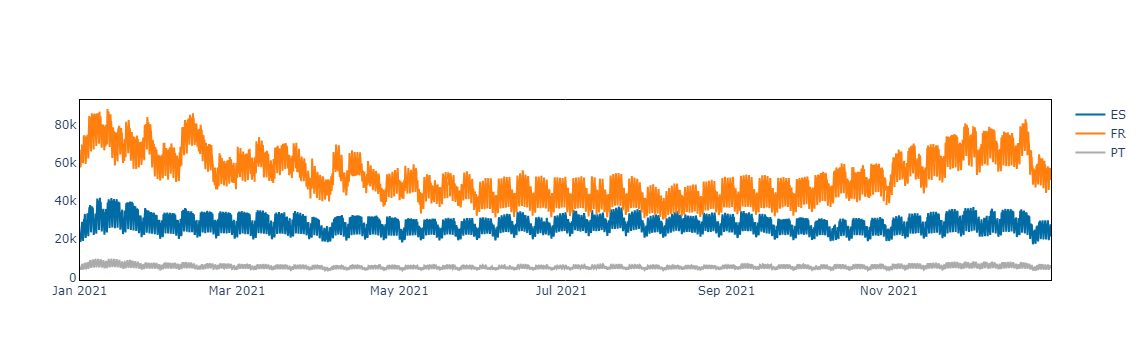

In [18]:
fig = go.Figure()
for idx, tso in enumerate(TSOS):
    fig.add_trace(
        go.Scatter(
            x=loads[tso].index,
            y=loads[tso].to_numpy(),
            mode='lines',
            name=tso,
            marker=dict(color=colors[idx])
        )
    )

fig.update_layout(
    plot_bgcolor='white'
)
fig.update_xaxes(
    mirror=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.show()

In [ ]:
### Extract crossborder physical flows for ES, PT and FR (using RESTful API)

In [19]:
links = ["ES_FR", "FR_BE", "FR_CH", "FR_DE", "FR_IT", "FR_UK", "ES_PT"]
crossborder_exchanges = {}
progress = tqdm(links, desc="Reading crosborder exchanges", leave=True)
for link in progress:
    progress.set_description(f"Reading crossborder exchanges for {link}", refresh=True)
    tso1 = link.split("_")[0]
    tso2 = link.split("_")[1]
    url = rf"https://web-api.tp.entsoe.eu/api?securityToken={token}&documentType=A11&in_Domain={EIC_CODES[tso1]}&out_Domain={EIC_CODES[tso2]}&periodStart={YEAR}01010000&periodEnd={YEAR + 1}01010000"
    s = requests.get(url, proxies=proxies).text
    df1 = pd.read_xml(io.StringIO(s), xpath=".//xmlns:Point", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:0"})["quantity"].squeeze()
    url = rf"https://web-api.tp.entsoe.eu/api?securityToken={token}&documentType=A11&in_Domain={EIC_CODES[tso2]}&out_Domain={EIC_CODES[tso1]}&periodStart={YEAR}01010000&periodEnd={YEAR + 1}01010000"
    s = requests.get(url, proxies=proxies).text
    df2 = pd.read_xml(io.StringIO(s), xpath=".//xmlns:Point", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:0"})["quantity"].squeeze()
    crossborder_exchanges[link] = df2 - df1

Reading crosborder exchanges:   0%|          | 0/7 [00:00<?, ?it/s]

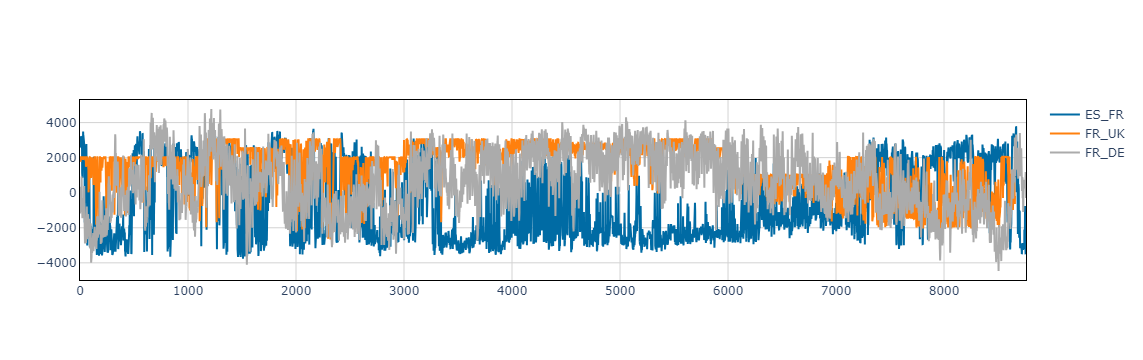

In [21]:
fig = go.Figure()
for idx, link in enumerate(["ES_FR", "FR_UK", "FR_DE"]):
    fig.add_trace(
        go.Scatter(
            x=crossborder_exchanges[link].index,
            y=crossborder_exchanges[link].to_numpy(),
            mode='lines',
            name=link,
            marker=dict(color=colors[idx])
        )
    )

fig.update_layout(
    plot_bgcolor='white'
)
fig.update_xaxes(
    mirror=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.show()

In [ ]:
pd.read_xml(io.StringIO(s), xpath=".//xmlns:Point", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"})

In [ ]:
print(s)

In [ ]:
s = requests.get(url, proxies=proxies).text
pd.read_xml(io.StringIO(s), xpath=".//xmlns:Point", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:0"})

In [ ]:
pd.read_xml(io.StringIO(s), xpath=".//xmlns:MktPSRType", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"})

In [ ]:
url = rf"https://web-api.tp.entsoe.eu/api?securityToken={token}&documentType=A75&processType=A16&in_Domain={EIC_CODES['ES']}&periodStart={YEAR}01010000&periodEnd={YEAR + 1}01010000"

In [9]:
base_folder = Path(r"D:\Users\guyfab\Documents\Codes\lfe_summit")

### Extract load data for ES, PT and FR

In [ ]:
tsos = ["ES", "FR", "PT"]
load = pd.concat(
    [
        pd.read_csv(
            base_folder / f"{tso}_Total Load - Day Ahead _ Actual_202101010000-202201010000.csv",
            sep=",",
            index_col=0,
            usecols=lambda x: x.startswith(("Time", "Actual Total Load")),
        )
        for tso in tsos
    ], axis=1
).reset_index(drop=True)
load = load.rename(columns={col: re.sub(r"[a-zA-Z \[\]-]*\((.*)\)", r'\1_load', col) for col in load.columns})

In [ ]:
generation = pd.concat(
    [
        pd.read_csv(
            base_folder / f"{tso}_Actual Generation per Production Type_202101010000-202201010000.csv",
            sep=",",
            index_col=0,
            na_values="n/e"
        )
        .reset_index(drop=True)
        .rename(columns=lambda x: tso + "_" + x)
        for tso in tsos
    ], axis=1
)

In [ ]:
for tso in tsos:
    generation[tso + "_total"] = generation.filter(regex=tso + ".*Aggregated").select_dtypes(include="number").sum(axis=1) - generation.filter(regex=tso + ".*Consumption").select_dtypes(include="number").sum(axis=1)

### Extract crossborder flows for ES, PT and FR

In [10]:
links = ["ES_FR", "FR_BE", "FR_CH", "FR_DE", "FR_IT", "FR_UK", "ES_PT"]
crossborders_flows = pd.concat(
    [
        pd.read_csv(base_folder / f"{link}_Cross-Border Physical Flow_202101010000-202201010000.csv", sep=",", index_col=0).reset_index(drop=True)
        for link in links
    ], axis=1
)
crossborders_flows = crossborders_flows.rename(columns={col: re.sub(r"[a-zA-Z ]*\((.*)\) > [a-zA-Z ]*\((.*)\) \[MW\]", r'\1_\2', col) for col in crossborders_flows.columns})

In [11]:
for link in links:
    crossborders_flows[link] = crossborders_flows[link] - crossborders_flows[link.split("_")[1] + "_" + link.split("_")[0]]
crossborders_flows = crossborders_flows[links]

In [12]:
crossborders_flows

ES_FR   FR_BE   FR_CH   FR_DE   FR_IT   FR_UK   ES_PT
0     1731.0  -477.0  -542.0 -1235.0   371.0  2019.0  -320.0
1     2573.0  -645.0  -470.0 -1122.0   491.0  2019.0  -283.0
2     3176.0  -906.0  -358.0 -1189.0   262.0  2019.0   -98.0
3     3210.0  -159.0    92.0  -414.0   412.0  2019.0   334.0
4     3212.0   207.0   591.0   335.0   557.0  1819.0  1034.0
...      ...     ...     ...     ...     ...     ...     ...
8756 -3503.0 -2088.0   941.0   431.0  2676.0    53.0 -2055.0
8757 -3517.0 -1776.0  1228.0   775.0  2720.0  -411.0 -1784.0
8758 -3079.0 -1386.0  1564.0  1182.0  2643.0  -616.0 -1327.0
8759 -1930.0 -1667.0  1180.0   441.0  2298.0  -266.0  -934.0
8760 -1905.0 -1862.0  1191.0   397.0  1941.0  -641.0   -62.0

[8761 rows x 7 columns]

### Check that balances are correct for each TSO

In [ ]:
balance_es_p_c = generation["ES_total"] - load["ES_load"]
balance_es_exchanges =  crossborders_flows["ES_FR"] + crossborders_flows["ES_PT"]

In [ ]:
balance_pt_p_c = generation["PT_total"] - load["PT_load"]
balance_pt_exchanges =  -crossborders_flows["ES_PT"]

In [ ]:
balance_fr_p_c = generation["FR_total"] - load["FR_load"]
balance_fr_exchanges =  -crossborders_flows["ES_FR"] + crossborders_flows["FR_BE"] + crossborders_flows["FR_DE"] + crossborders_flows["FR_CH"]+ crossborders_flows["FR_IT"] + crossborders_flows["FR_UK"] 

In [ ]:
(crossborders_flows["FR_BE"] + crossborders_flows["FR_DE"] + crossborders_flows["FR_CH"]+ crossborders_flows["FR_IT"] + crossborders_flows["FR_UK"]).describe()

In [ ]:
(balance_es_p_c + balance_pt_p_c + balance_fr_p_c - (crossborders_flows["FR_BE"] + crossborders_flows["FR_DE"] + crossborders_flows["FR_CH"]+ crossborders_flows["FR_IT"] + crossborders_flows["FR_UK"])).describe()

In [ ]:
balance_fr_p_c

In [ ]:
(balance_pt_exchanges - balance_pt_p_c).describe()

In [ ]:
(balance_es_exchanges - balance_es_p_c).describe()

In [ ]:
gen_pt = gen["PT"].select_dtypes(include="number").sum(axis=1) - 2 * gen["PT"]["Hydro Pumped Storage  - Actual Consumption [MW]"]
load_pt = load["PT"].squeeze()

In [ ]:
balance = exchanges["Portugal (PT) > Spain (ES) [MW]"] - exchanges["Spain (ES) > Portugal (PT) [MW]"]

In [ ]:
(gen_pt - load_pt).dropna().plot()